In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

[  0  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  40  41  42  43  44  46  47  48  50  52  53  56  57  58  61  64
  65  67  68  70  72  74  78  79  86  88  90  92  97  99 100]


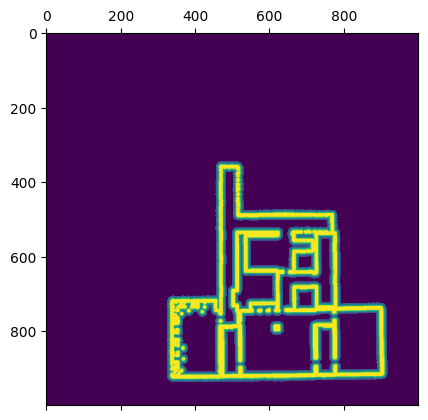

In [3]:
with open('../to_be_saved/occupancy_grid.npy', 'rb') as f:
    occupancy_grid = np.load(f)

print(np.unique(occupancy_grid))

plt.matshow(occupancy_grid)

Binary split down the occupancy map, only drive thorugh places were we know the car would fit through any configuration

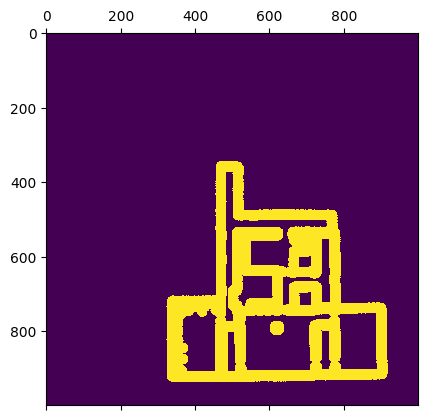

In [4]:
occupancy_grid_filtered = (occupancy_grid != 0)*1
plt.matshow(occupancy_grid_filtered)


In [16]:
def find_reachable_points(x_start, y_start, binary_occupancy_grid: np.ndarray):
    # create a grid to save values in (0) for unlcear, (1) for reachable, (2) for fatal
    reachability_grid = binary_occupancy_grid.copy() * 2

    # check start point is valid
    assert x_start >=0 and y_start >= 0 and y_start < reachability_grid.shape[0] and x_start < reachability_grid.shape[1]
    assert reachability_grid[y_start, x_start] != 2

    # start recursiv fnding
    recursive_find_new_points(x_start, y_start, reachability_grid)

    return reachability_grid


def recursive_find_new_points(x,y, reachability_grid: np.ndarray):
    assert reachability_grid[y,x] == 0

    # Step 1 -> set current point as reachable
    reachability_grid[y, x] = 1

    # Step 2 -> go in every direction and start again
    # defin helper function
    def check_new_point(x, y, reachability_grid: np.ndarray):
        # we are inbound
        if x>=0 and y>= 0 and y < reachability_grid.shape[0] and x < reachability_grid.shape[1]:
            if reachability_grid[y,x] == 0:
                return True
        return  False

    for x_dir in [-1, 0, 1]:
        for y_dir in [-1, 0, 1]:
            if check_new_point(x+x_dir, y+y_dir, reachability_grid):
                recursive_find_new_points(x+x_dir, y+y_dir, reachability_grid)


    

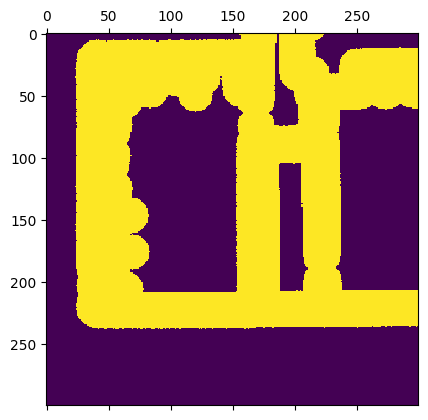

In [17]:
sys.getrecursionlimit()
sys.setrecursionlimit(20000)
occupancy_grid_filtered.shape

occupancy_grid_filtered_reshaped = occupancy_grid_filtered[700:1000, 300:600]

plt.matshow(occupancy_grid_filtered_reshaped)

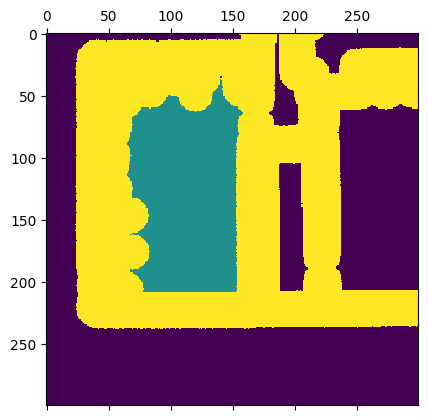

In [19]:

reachbility_grid = find_reachable_points(130, 150, occupancy_grid_filtered_reshaped)
plt.matshow(reachbility_grid)

Implement Simple A star finder to get shortest distance between points

In [22]:
import heapq

def heuristic(a, b):
    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)

def backsolve_path(end, came_from):
    print("backsolve_path")
    current = end
    path = []
    while current in came_from:
        path.append(current)
        current = came_from[current]
    return path

def check_new_point(point, reachability_map: np.ndarray):
    if point[0] < 0 or point[0] > reachability_map.shape[1]:
        return False
    if point[1] < 0 or point[1] > reachability_map.shape[0]:
        return False
    if reachability_map[point[1], point[0]] != 1:
        return False
    
    return True

def a_star(start, goal, reachability_map: np.ndarray):
    start = (start[1], start[0])
    goal=(goal[1], goal[0])

    assert reachability_map[start] == 1 and reachability_map[goal] == 1

    # allow moves in all directions
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    
    open_heap = []
    closed_set = set()

    came_from = {}
    
    # add initial point to open list
    gscore = {start: 0}
    fscore={start: heuristic(start, goal)}

    heapq.heappush(open_heap, (fscore[start], start))

    while open_heap:
        current = heapq.heappop(open_heap)[1]

        # reached goal -> backwards calculate path
        if current == goal:
            return backsolve_path(current, came_from)

        # Continue path finding
        closed_set.add(current)

        # go over all neighbors
        for i, j in neighbors:
            neighbor = current[0]+i, current[1]+j

            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            
            if not check_new_point((neighbor[1], neighbor[0]), reachability_map):
                continue
            
            if neighbor in closed_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
            
            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in open_heap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                
                heapq.heappush(open_heap, (fscore[neighbor], neighbor))


backsolve_path


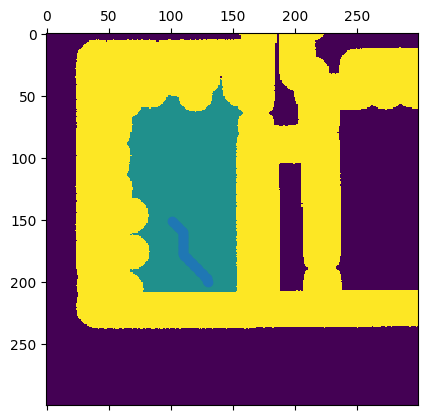

In [23]:
path = a_star((100,150), (130,200), reachbility_grid)

plt.matshow(reachbility_grid)
plt.scatter([p[1] for p in path], [p[0] for p in path])